In [1]:
import os

%matplotlib inline
import numpy as np
from photutils.aperture import EllipticalAperture
from astropy.io import fits
import matplotlib.pylab as plt
from astropy.visualization import ImageNormalize
from astropy.visualization import simple_norm, MinMaxInterval, PercentileInterval, ZScaleInterval

%matplotlib inline

In [2]:
from matplotlib import rcParams

rcParams["figure.figsize"] = (15*2, 7*2)
rcParams["font.size"] = 8*2

In [18]:
def show_image(image, cmap):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plot = ax.imshow(image, cmap)
    

In [3]:
def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape
    
    noise = noise_rng.normal(scale=amount/gain, size=shape)
    
    return noise

In [4]:
def bias(image, value, realistic=False):
    """
    Generate simulated bias image.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the bias array should match.
    value: float
        Bias level to add.
    realistic : bool, optional
        If ``True``, add some columns with somewhat higher bias value (a not uncommon thing)
    """
    # This is the whole thing: the bias is really suppose to be a constant offset!
    bias_im = np.zeros_like(image) + value
    
    # If we want a more realistic bias we need to do a little more work. 
    if realistic:
        shape = image.shape
        number_of_colums = 5
        
        # We want a random-looking variation in the bias, but unlike the readnoise the bias should 
        # *not* change from image to image, so we make sure to always generate the same "random" numbers.
        rng = np.random.RandomState(seed=8392)  # 20180520
        columns = rng.randint(0, shape[1], size=number_of_colums)
        # This adds a little random-looking noise into the data.
        col_pattern = rng.randint(0, int(0.1 * value), size=shape[0])
        
        # Make the chosen columns a little brighter than the rest...
        for c in columns:
            bias_im[:, c] = value + col_pattern
            
    return bias_im

In [5]:
def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simulate dark current in a CCD, optionally including hot pixels.
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    current : float
        Dark current, in electrons/pixel/second, which is the way manufacturers typically 
        report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    strength : float, optional
        Pixel count in the cosmic rays.    
    """
    
    # dark current for every pixel; we'll modify the current for some pixels if 
    # the user wants hot pixels.
    base_current = current * exposure_time / gain
    
    # This random number generation should change on each call.
    dark_im = noise_rng.poisson(base_current, size=image.shape)
        
    if hot_pixels:
        # We'll set 0.01% of the pixels to be hot; that is probably too high but should 
        # ensure they are visible.
        y_max, x_max = dark_im.shape
        
        n_hot = int(0.0001 * x_max * y_max)
        
        # Like with the bias image, we want the hot pixels to always be in the same places
        # (at least for the same image size) but also want them to appear to be randomly
        # distributed. So we set a random number seed to ensure we always get the same thing.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        hot_current = 10000 * current
        
        dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain
    return dark_im

In [14]:
def sky_background(image, sky_counts, gain=1):
    """
    Generate sky background, optionally including a gradient across the image (because
    some times Moons happen).
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    sky_counts : float
        The target value for the number of counts (as opposed to electrons or 
        photons) from the sky.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    sky_im = noise_rng.poisson(sky_counts * gain, size=image.shape) / gain
    
    return sky_im

In [6]:
# Set up the random number generator, allowing a seed to be set from the environment
seed = os.getenv('GUIDE_RANDOM_SEED', None)

if seed is not None:
    seed = int(seed)
    
# This is the generator to use for any image component which changes in each image, e.g. read noise
# or Poisson error
noise_rng = np.random.default_rng(seed)

In [7]:
synthetic_image = np.zeros([1000, 1000])

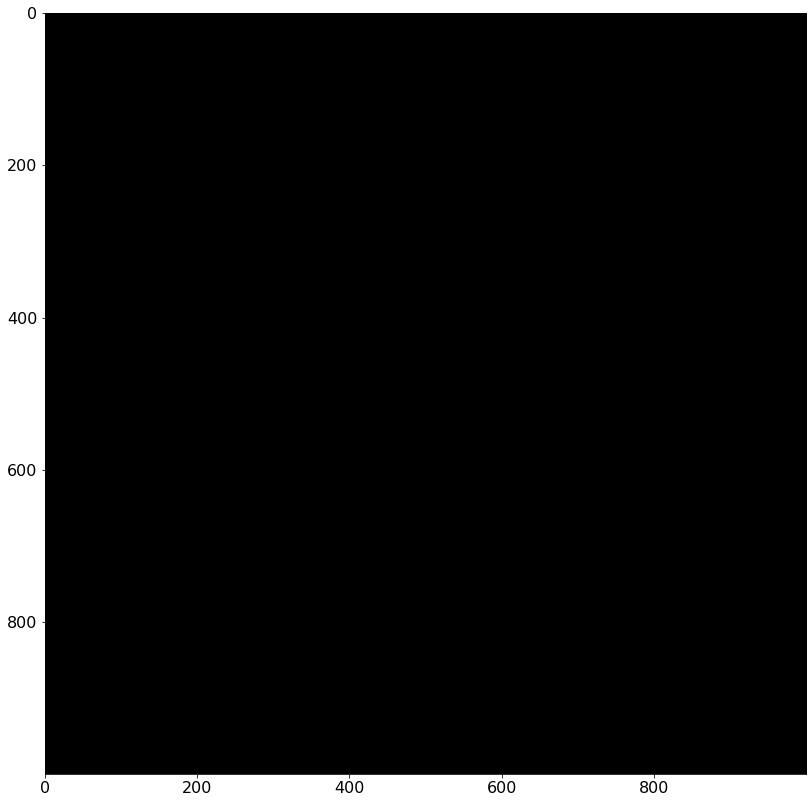

In [19]:
show_image(synthetic_image, cmap='gray')


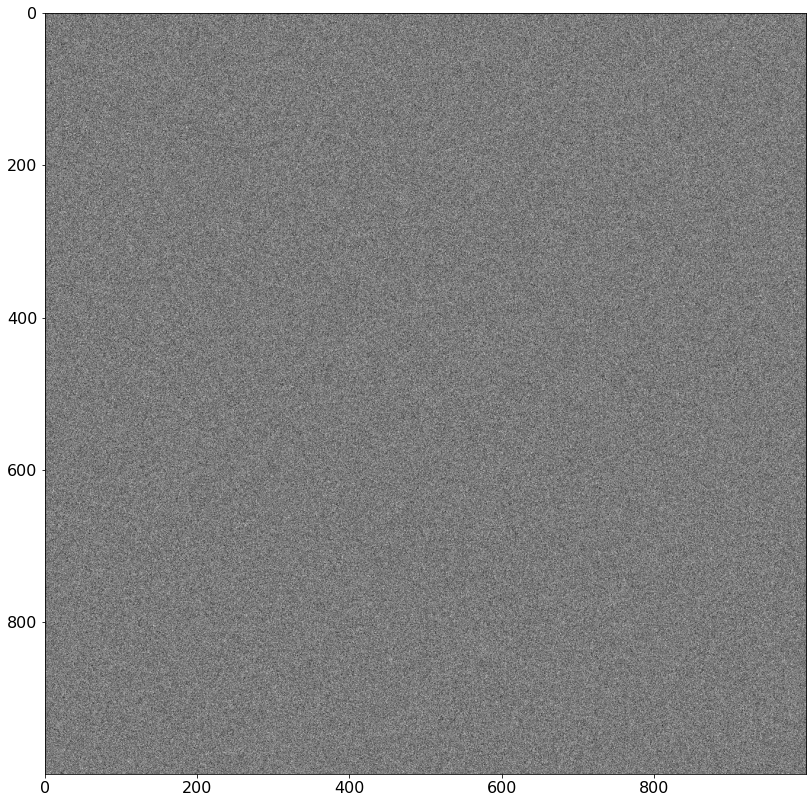

In [9]:
noise_im = synthetic_image + read_noise(synthetic_image, 5)
fig = plt.figure()
ax =fig.add_subplot(1, 1, 1)
plot = ax.imshow(noise_im, cmap='gray')

Text(0.5, 1.0, 'Bias alone, bad columns included')

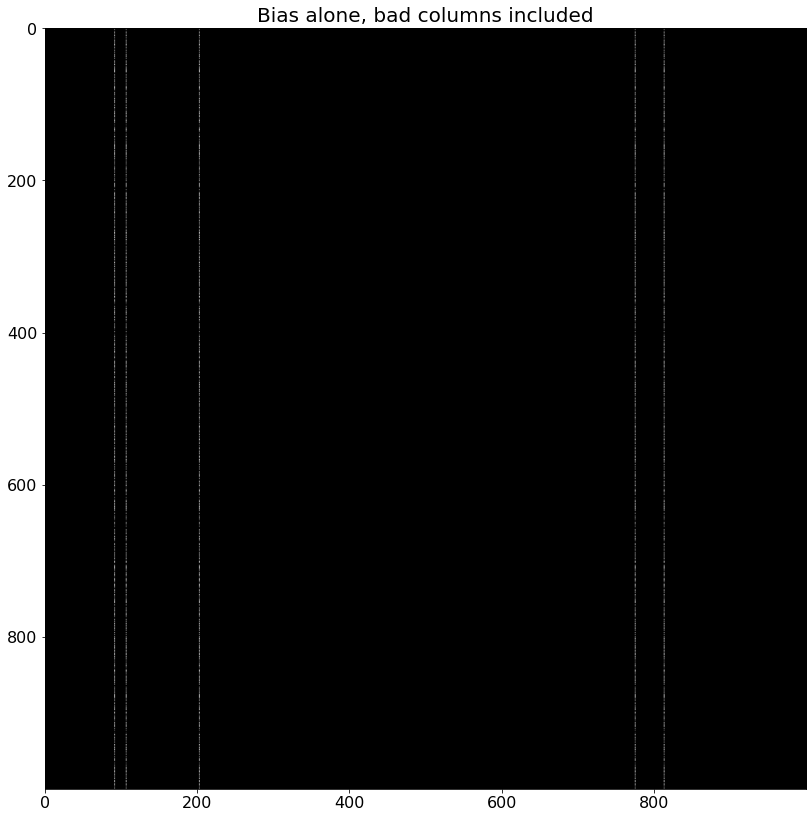

In [17]:
bias_only = bias(synthetic_image, 1100, realistic=True)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot = ax.imshow(bias_only, cmap='gray')
plt.title('Bias alone, bad columns included', fontsize='20')

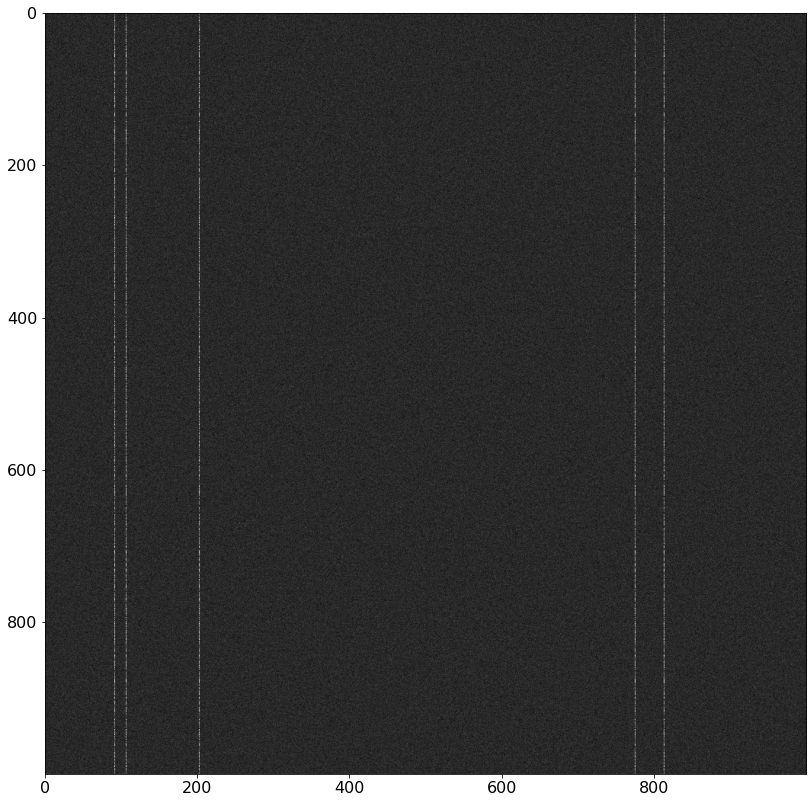

In [11]:
bias_noise_im = noise_im + bias_only
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot = ax.imshow(bias_noise_im, cmap='gray')

C:\Users\Saike\AppData\Local\Temp/ipykernel_17860/116257232.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain


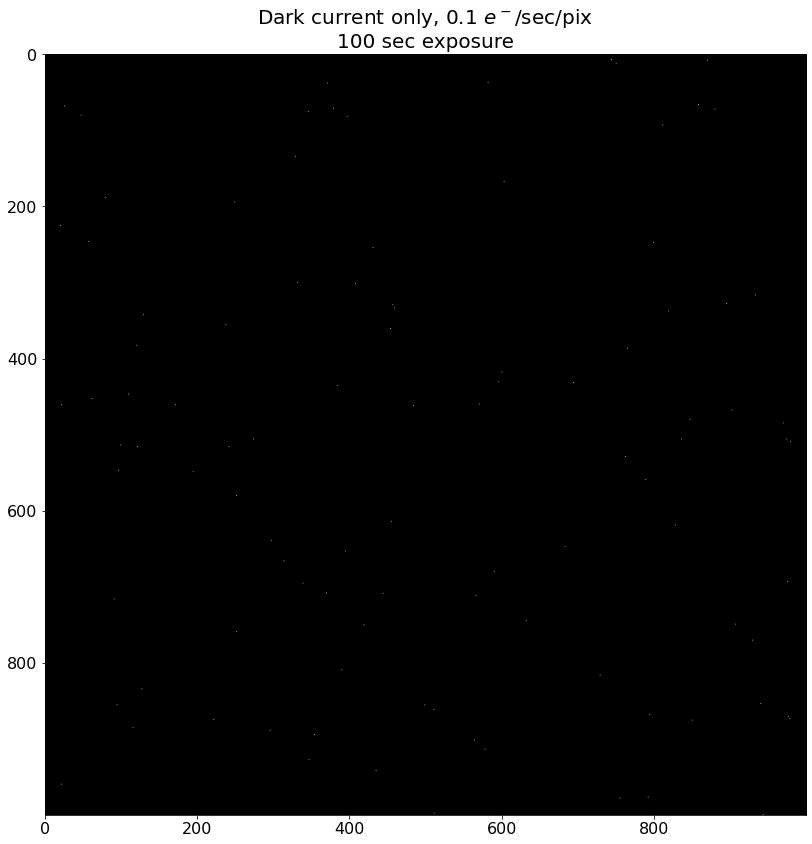

In [12]:
dark_exposure = 100
dark_cur = 0.1
dark_only = dark_current(synthetic_image, dark_cur, dark_exposure, hot_pixels=True)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot = ax.imshow(dark_only, cmap='gray')
title_string = 'Dark current only, {dark_cur} $e^-$/sec/pix\n{dark_exposure} sec exposure'.format(dark_cur=dark_cur, dark_exposure=dark_exposure)
plt.title(title_string, fontsize='20');

Text(0.5, 1.0, 'Realistic dark frame \n(with bias, read noise)')

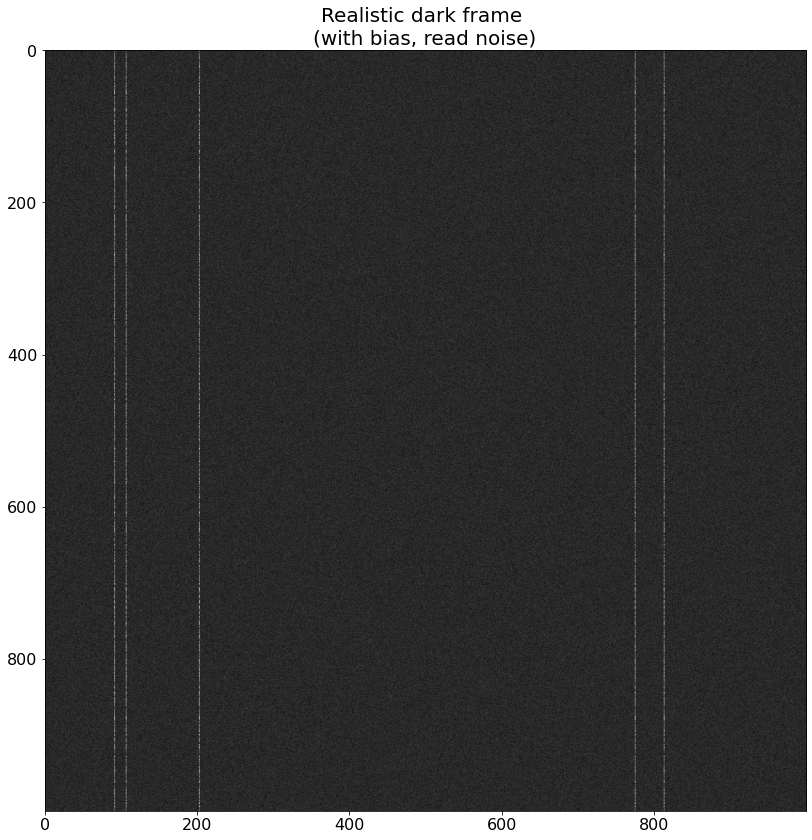

In [13]:
dark_bias_noise_im = bias_noise_im + dark_only
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot = ax.imshow(bias_noise_im, cmap='gray')
plt.title('Realistic dark frame \n(with bias, read noise)', fontsize='20')